In [1]:
import sys, importlib, os, time
# "../" to go back one director
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
# from Modules.Utils.Imports import *
# from Modules.Utils.Gradient import Gradient
# from Modules.Utils.ModelWrapper import ModelWrapper
# from Modules.Models.BuildSurfaceFitter import *

import numpy as np
# import DataFormatter as DF
import matplotlib.pyplot as plt

from scipy import integrate
from scipy import sparse
from scipy import optimize
# from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import scipy.io
from scipy import integrate, interpolate
from scipy.sparse import spdiags
from scipy import sparse
from scipy.optimize import linprog
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from itertools import repeat

In [2]:
def ProhorovitError(w, U_sim, u_data):
    ''' return the sum of squares error when using Prokhorov metrics framework
    '''
    nums, _, _ = U_sim.shape
    best_approx = np.zeros((u_data.shape))

    for i in range(len(w)):
        best_approx += w[i]*np.squeeze(U_sim[i,:,:])
    residual = (best_approx - u_data)**2

    return sum(sum(residual))

def constraints(w):
    ''' constraints function for the weights
    '''
    return 1.0 - sum(w)

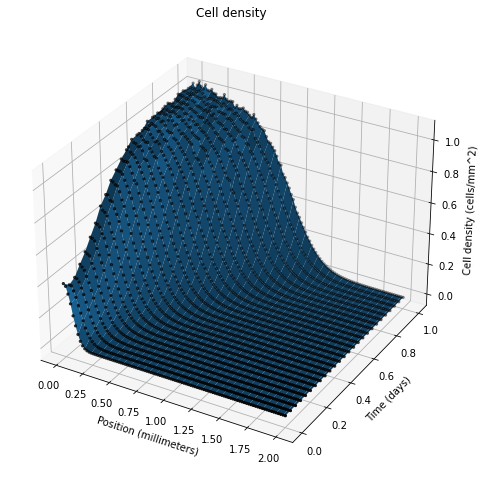

In [3]:
# Load data
path = os.getcwd()+'/NPY_Data/data_wider_2P_E2.npy'
data = np.load(path, allow_pickle=True).item()

x = data['x']
t = data['t']
t = t[:26]
U = data['u_noise']
U = U[:,:26]
X, T = np.meshgrid(x, t, indexing='ij')

shape = U.shape

# flatten for MLP
inputs = np.concatenate([X.reshape(-1)[:, None],
                         T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]


# plot surface
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, T, U)#, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), T.reshape(-1), U.reshape(-1), s=5, c='k')
plt.title('Cell density')
ax.set_xlabel('Position (millimeters)')
ax.set_ylabel('Time (days)')
ax.set_zlabel('Cell density (cells/mm^2)')
#ax.set_zlim(0, 2.2e3)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout(pad=2)
plt.show()

In [4]:
# Get data
u_data = outputs.reshape(shape)
x = data['x']
t = data['t']

# Define the maximum numbers of nodes
max_D_nodes = 20
max_rho_nodes = 20
max_K_nodes = 1

D_min = 0.0
D_max = 0.12
rho_min = 0.0
rho_max = 12.0
K_min = 1.0
K_max = 1.0

D_vec = np.linspace(D_min, D_max, max_D_nodes)
rho_vec = np.linspace(rho_min, rho_max, max_rho_nodes)
K_vec = np.linspace(K_min, K_max, max_K_nodes)

data_dir = os.getcwd()+'/PrecomputedSolutions_Interp_2P_E2/'

U_sim = np.zeros((max_D_nodes, max_rho_nodes, shape[0], shape[1]))

Forward_time = 0

# Load all precomputed solutions
for iD in np.arange(max_D_nodes):
    for iRho in np.arange(max_rho_nodes):
        file_name = data_dir+'Sol_'+str(int(iD)+1).zfill(3)+'_'+str(int(iRho)+1).zfill(3)+'.npy'
        
        file_data = np.load(file_name, allow_pickle=True).item()
        
        U_sim[iD, iRho, :, :] = file_data['u_sim']
        
        Forward_time = Forward_time + file_data['elapsed_time']

In [5]:
# Define numbers of nodes for low-resolution distributions
num_D_nodes = [5, 10, 20]
num_rho_nodes = [5, 10, 20]

num_run = 20
np.random.seed(seed=42)
time_start = time.time()

for num_D_node in num_D_nodes:
    for num_rho_node in num_rho_nodes:

        count = num_D_node*num_rho_node
        D_vec_idx = np.floor(np.linspace(0,max_D_nodes-1, num_D_node))
        rho_vec_idx = np.floor(np.linspace(0,max_rho_nodes-1, num_rho_node))
        D_vec_idx = D_vec_idx.astype(int)
        rho_vec_idx = rho_vec_idx.astype(int)

        u_temp = U_sim[D_vec_idx, :, :, :]
        u_temp = u_temp[:, rho_vec_idx, :, :]

        u_temp_reshaped = u_temp.reshape((-1, shape[0], shape[1]))

        # Setting up bounds
#        lb =  np.zeros((count, 1))
#        ub =  np.ones((count, 1))
#        bnds = Bounds(lb, ub)
        test_tup = (0, 1)
        N = count
        bnds = tuple(repeat(test_tup, N))
        
        # Setting up constrainst
        cons = {'type':'eq', 'fun': constraints}
        cons = [cons]

        #make a wrapper objective function
        def objective(w):
            return ProhorovitError(w, u_temp_reshaped, u_data)
        
        pmf_error = 1e16
        best_results = {}
        
        save_file = 'PMF_Results_Interp_2P_E2/'+'PMF_'+str(num_D_node).zfill(3)+'_'+str(num_rho_node).zfill(3)+'.npy'
        
        # Run PMF approach for 20 initial weights
        for irun in np.arange(num_run):

            # initialize weights
            w0 = np.random.rand(count,1)
            w0 = w0/count
            # find the optimal weights
            sol = minimize(fun=objective, x0=w0, bounds=bnds, constraints=cons)
            optimized_fval = sol.fun
            optimized_w = sol.x

            if optimized_fval < pmf_error:
                pmf_error = optimized_fval
                best_w0 = w0
                best_w  = optimized_w
                
                best_results['best_error'] = pmf_error
                best_results['best_w0'] = best_w0
                best_results['best_w'] = best_w
                np.save(save_file, best_results)
                


In [4]:
numX = len(x)
numT = len(t)
numData = numX*numT
numData = np.float(numData)

# Compute the AIC score and save the combination of nodes with lowest AIC score
best_AIC_score = 1e16
best_AIC = {}
for num_D_node in num_D_nodes:
    for num_rho_node in num_rho_nodes:
        load_file = 'PMF_Results_Interp_2P_E2/'+'PMF_'+str(num_D_node).zfill(3)+'_'+str(num_rho_node).zfill(3)+'.npy'
        
        best_results = np.load(load_file, allow_pickle=True).item()
        RSS = best_results['best_error']
        
        numPar = num_D_node*num_rho_node
        numPar = np.float(numPar)
        # Compute AIC score
        AIC = numData*np.log(RSS/numData) + numData*(1+np.log(2*np.pi)) + 2*(numPar+1)

        if AIC < best_AIC_score:
            best_AIC_score = AIC
            best_RSS = RSS
            best_numDnode = num_D_node
            best_numRhonode = num_rho_node
            best_weights  = best_results['best_w']
            
            best_AIC['AIC_score'] = best_AIC_score
            best_AIC['best_RSS'] = best_RSS
            best_AIC['best_numDnode'] = best_numDnode
            best_AIC['best_numRhonode'] = best_numRhonode
            best_AIC['best_weights'] = best_weights

PMF_time = time.time() - time_start
total_time = Forward_time + PMF_time
best_AIC['total_time'] = total_time
best_AIC['PMF_time'] = PMF_time
best_AIC['Fordward_time'] = Forward_time

save_path = 'PMF_Results_Interp_2P_E2/best_PMF.npy'
np.save(save_path, best_AIC)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


NameError: name 'num_D_nodes' is not defined